In [51]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils import data

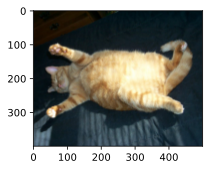

In [52]:
d2l.set_figsize()
img = Image.open('./data/img/cat1.jpeg')
d2l.plt.imshow(img);

In [140]:
#把图片转化为tensor
img_tensor = torchvision.transforms.ToTensor()(img)

In [153]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    print(image.shape)
#     image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
        plt.pause(0.001)

torch.Size([3, 400, 500])


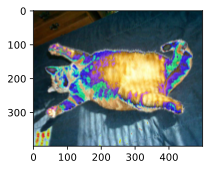

In [154]:
imshow(img_tensor)

## 归一化处理

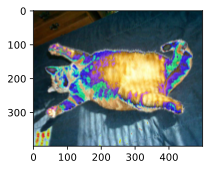

In [141]:
img_tensor = torchvision.transforms.ToTensor()(img)
img_tensor = torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])(img_tensor)
imshow(img_tensor)

In [112]:
def image_show(images,row_num,col_num,title=None,scale=1.5):
    figsize = (col_num*scale,row_num*scale)
    _,ax = d2l.plt.subplots(row_num,col_num,figsize=figsize)
    axes = ax.flatten()
    for _,(image,ax) in enumerate(zip(images,axes)):
        if torch.is_tensor(image):
            ax.imshow(image.numpy())
        else:
            ax.imshow(image)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

In [80]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

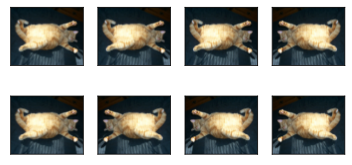

In [81]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

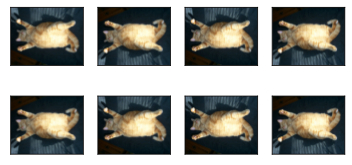

In [82]:
apply(img, torchvision.transforms.RandomVerticalFlip())

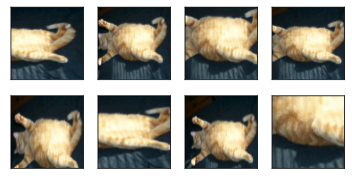

In [83]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

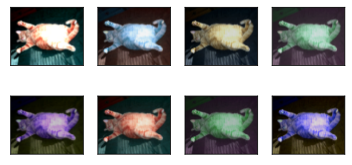

In [156]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

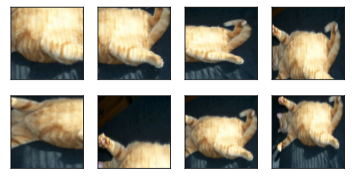

In [159]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


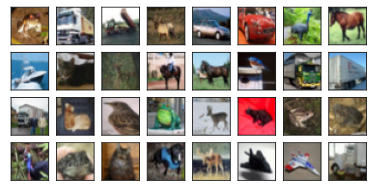

In [160]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [167]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [168]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [169]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

In [173]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=torch.device('mps')):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

Files already downloaded and verified
Files already downloaded and verified


/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c1014SymIntArrayRefENS2_8optionalINS2_10ScalarTypeEEENS4_INS2_6LayoutEEENS4_INS2_6DeviceEEENS4_IbEENS4_INS2_12MemoryFormatEEE)
  Referenced from: '/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")
/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c1014SymIntArrayRefENS2_8op

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_40270/2206566086.py", line 1, in <cell line: 1>
    train_with_data_aug(train_augs, test_augs, net)
  File "/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_40270/3088660611.py", line 14, in train_with_data_aug
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)
  File "/var/folders/j9/x9wd0pm15rgd97b0jsp8sk100000gn/T/ipykernel_40270/2534112030.py", line 31, in train_ch13
    for i, (features, labels) in enumerate(train_iter):
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 681, in __next__
    data = self._next_data()
  File "/Users/chengwei/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1357, 

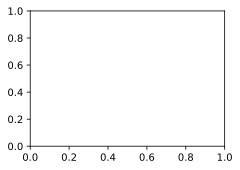

In [174]:
train_with_data_aug(train_augs, test_augs, net)